In [28]:
#%pip install matplotlib
#%pip install seaborn

import pandas as pd
import csv

PATH = r"C:\Users\HP PAVILION 15 CS\OneDrive\loan_default_model_Ren\homework-data.csv"

# 1) Read & parse
rows = []
with open(PATH, newline="", encoding="utf-8") as f:
    reader = csv.reader(f)            # reads each line into a list, splitting on commas
    for row in reader:
        # row[0] is the quoted tab-string, row[1:], if any, are just '' empty columns
        main = row[0]                 # e.g. "\tLoanAmount\tCreationDate\t…"
        # strip surrounding quotes and any trailing commas, then split on tabs
        parts = main.strip().strip('"').split("\t")
        rows.append(parts)

# 2) Build DataFrame
header, data = rows[0], rows[1:]
# Add an index column name to match the data
header = ['Index'] + header
df = pd.DataFrame(data, columns=header)

# 3) (Optional) convert types
df["LoanAmount"] = pd.to_numeric(df["LoanAmount"], errors="coerce")
df["CreationDate"] = pd.to_datetime(df["CreationDate"], errors="coerce")
# …and so on for other columns…

# 4) Inspect
print(df.shape)
df.head()



(3621, 39)


,Index,LoanAmount,CreationDate,fpd_15,data.Request.Input.CB2.MaxDPD,data.Request.Input.CB2.Labelling,data.Request.Input.CB2.CurrentDPD,data.Request.Input.CB2.Outstandingloan,data.Request.Input.CB1.MaxDPD,data.Request.Input.CB1.Labelling,...,data.Request.Input.SalaryService.MinimumCredit,data.Request.Input.SalaryService.AvgNumDebitMn,data.Request.Input.SalaryService.MonthlyCashFlow2,data.Request.Input.SalaryService.MonthlyCashFlow3,data.Request.Input.BVN.StateOfOrigin,data.Request.Input.PrevApplication.LoanAmount,data.Request.Input.PrevApplication.LoanTerm,data.Request.Input.PrevApplication.InterestRate,data.Request.Input.Application.RequestedLoanTerm,data.Request.Input.SalaryService.OpeningBalance
0,0,1410000.0,2023-09-04,0,0.0,Sub-Prime,0.0,70000.0,0.0,Prime,...,,,,,Jigawa State,,,,17.0,None
1,1,710000.0,2023-06-26,0,,Near-Prime,,0.0,0.0,Near-Prime,...,0.0,100.0,11000.0,-2000.0,Niger State,,,,18.0,45000.0
2,2,5640000.0,2023-08-20,0,0.0,NTC,0.0,20000.0,,Prime,...,,,,,Ogun State,4802000.0,18.0,12.0,14.0,None
3,3,120000.0,2023-05-22,1,0.0,Prime,0.0,0.0,0.0,NTC,...,,,,,Cross River State,262000.0,15.0,13.0,14.0,None
4,4,160000.0,2023-05-17,0,0.0,Sub-Prime,0.0,140000.0,,Sub-Prime,...,,,,,Abia State,,,,12.0,None


In [33]:
num_cols = [
        "LoanAmount",
        "data.Request.Input.CB2.MaxDPD",
        "data.Request.Input.CB2.CurrentDPD",
        "data.Request.Input.CB2.Outstandingloan",
        "data.Request.Input.CB1.MaxDPD",
        "data.Request.Input.CB1.CurrentDPD",
        "data.Request.Input.CB1.Outstandingloan",
        "data.Request.Input.Customer.TotalExistingExposure",
        "data.Request.Input.Customer.Income.Final",
        "data.Request.Input.Customer.NumberOfChildren",
        "data.Request.Input.Customer.TimeAtAddressMM",
        "data.Request.Input.SalaryService.MonthlyElectricitySpending4",
        "data.Request.Input.SalaryService.MinimumBalance",
        "data.Request.Input.SalaryService.MinimumCredit",
        "data.Request.Input.SalaryService.AvgNumDebitMn",
        "data.Request.Input.SalaryService.MonthlyCashFlow2",
        "data.Request.Input.SalaryService.MonthlyCashFlow3",
        "data.Request.Input.PrevApplication.LoanAmount",
        "data.Request.Input.PrevApplication.LoanTerm",
        "data.Request.Input.PrevApplication.InterestRate",
        "data.Request.Input.Application.RequestedLoanTerm",
        "data.Request.Input.SalaryService.OpeningBalance",
        "fpd_15"
    ]

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

    # 3) Handle missing values
    # categorical → "Unknown"
cat_cols = df.select_dtypes(include="object").columns.difference(num_cols + ["CreationDate", "data.Request.Input.Customer.DateOfBirth"])
df[cat_cols] = df[cat_cols].fillna("Unknown")

    # numeric → median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # 4) Feature derivation
today = pd.Timestamp.today()

# Convert DateOfBirth to datetime
df["data.Request.Input.Customer.DateOfBirth"] = pd.to_datetime(
    df["data.Request.Input.Customer.DateOfBirth"], errors="coerce"
)

    # a) Age in years
df["Age"] = (
        today - df["data.Request.Input.Customer.DateOfBirth"]
    ).dt.days.div(365).round(1)
import numpy as np
# Ensure Age is non-negative
df["Age"] = df["Age"].clip(lower=0)
    # Ensure Age is finite
df["Age"] = df["Age"].replace([np.inf, -np.inf], np.nan).fillna(0)
    # Ensure Age is numeric
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")


    # b) Time on book in days
df["TimeOnBook"] = (
        today - df["CreationDate"]
    ).dt.days

    # c) Debt-to-Income ratio
df["DebtToIncome"] = (
        df["data.Request.Input.Customer.TotalExistingExposure"] 
        / df["data.Request.Input.Customer.Income.Final"]
    ).replace([np.inf, -np.inf], np.nan).fillna(0)


In [34]:
df.head()

,Index,LoanAmount,CreationDate,fpd_15,data.Request.Input.CB2.MaxDPD,data.Request.Input.CB2.Labelling,data.Request.Input.CB2.CurrentDPD,data.Request.Input.CB2.Outstandingloan,data.Request.Input.CB1.MaxDPD,data.Request.Input.CB1.Labelling,...,data.Request.Input.SalaryService.MonthlyCashFlow3,data.Request.Input.BVN.StateOfOrigin,data.Request.Input.PrevApplication.LoanAmount,data.Request.Input.PrevApplication.LoanTerm,data.Request.Input.PrevApplication.InterestRate,data.Request.Input.Application.RequestedLoanTerm,data.Request.Input.SalaryService.OpeningBalance,Age,TimeOnBook,DebtToIncome
0,0,1410000.0,2023-09-04,0,0.0,Sub-Prime,0.0,70000.0,0.0,Prime,...,-2000.0,Jigawa State,377000.0,13.0,12.0,17.0,30000.0,0.0,631,0.175391
1,1,710000.0,2023-06-26,0,0.0,Near-Prime,0.0,0.0,0.0,Near-Prime,...,-2000.0,Niger State,377000.0,13.0,12.0,18.0,45000.0,36.3,701,1.198997
2,2,5640000.0,2023-08-20,0,0.0,NTC,0.0,20000.0,0.0,Prime,...,-2000.0,Ogun State,4802000.0,18.0,12.0,14.0,30000.0,43.3,646,0.098621
3,3,120000.0,2023-05-22,1,0.0,Prime,0.0,0.0,0.0,NTC,...,-2000.0,Cross River State,262000.0,15.0,13.0,14.0,30000.0,30.0,736,0.105971
4,4,160000.0,2023-05-17,0,0.0,Sub-Prime,0.0,140000.0,0.0,Sub-Prime,...,-2000.0,Abia State,377000.0,13.0,12.0,12.0,30000.0,42.7,741,0.114135


In [35]:
  # 5) Save cleaned data
import os
import numpy as np
CLEAN_PATH = r"C:\Users\HP PAVILION 15 CS\OneDrive\loan_default_model_Ren\data\processed\cleaned_data.csv"
os.makedirs(os.path.dirname(CLEAN_PATH), exist_ok=True)
df.to_csv(CLEAN_PATH, index=False)
print(f"Cleaned data written to {CLEAN_PATH}")

Cleaned data written to C:\Users\HP PAVILION 15 CS\OneDrive\loan_default_model_Ren\data\processed\cleaned_data.csv


In [36]:
%pip install missingno

  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Note: you may need to restart the kernel to use updated packages.


<Figure size 200x300 with 0 Axes>

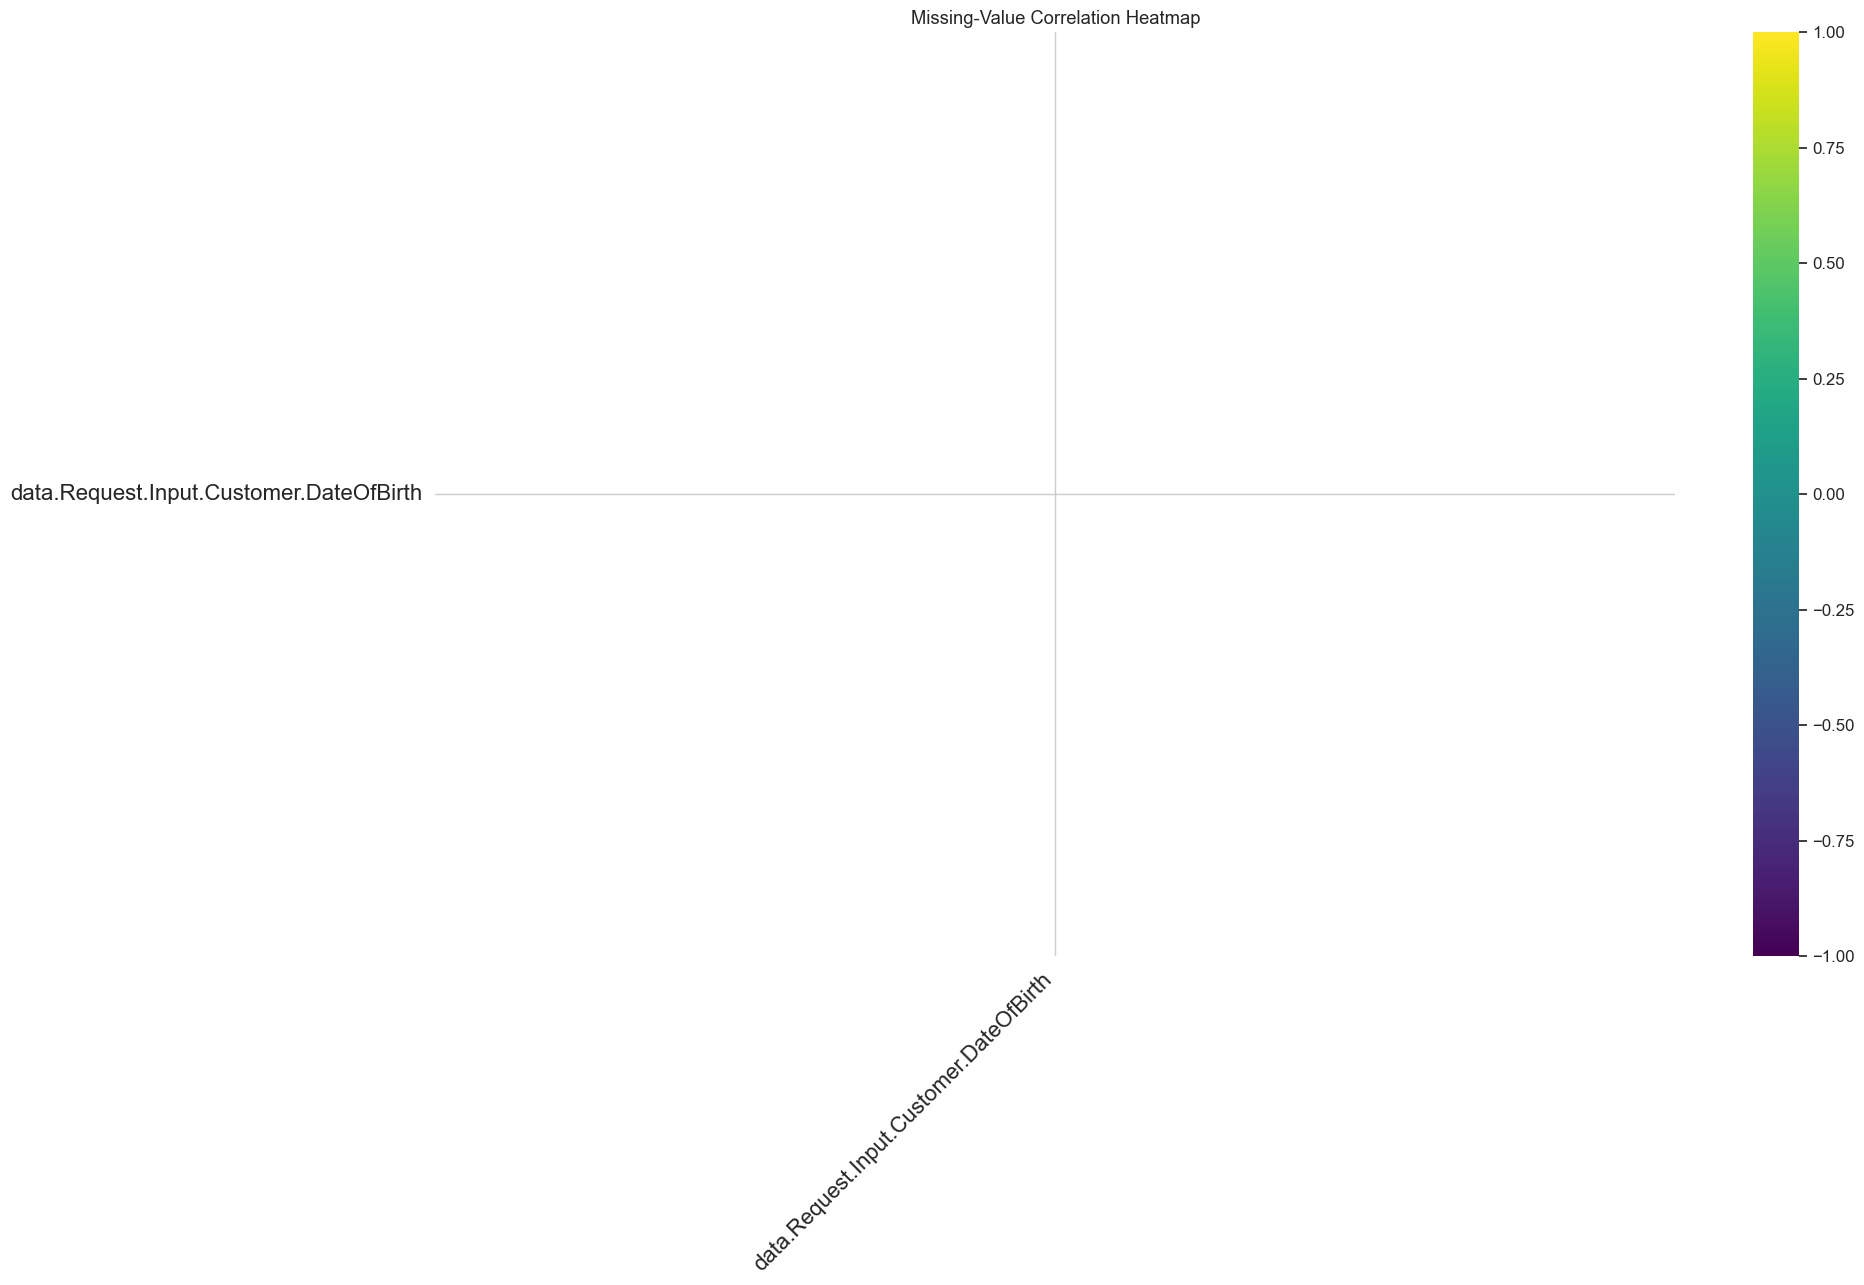

In [39]:


#Missing values heatmap
import missingno as msno

plt.figure(figsize=(2,3))
msno.heatmap(df, cmap="viridis")
plt.title("Missing-Value Correlation Heatmap")
plt.show()


fpd_15
0    0.555371
1    0.444629
Name: proportion, dtype: float64


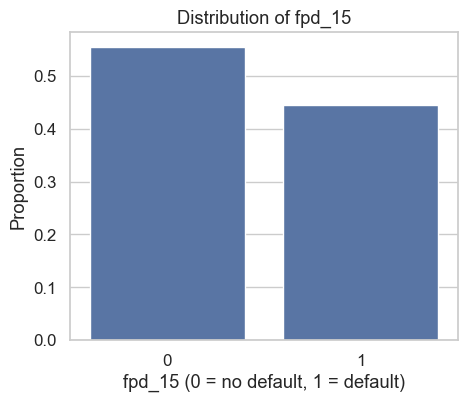

In [40]:
# Target Balance 
import matplotlib.pyplot as plt
import seaborn as sns

# proportion of defaults vs non-defaults
prop = df["fpd_15"].value_counts(normalize=True).sort_index()
print(prop)

plt.figure(figsize=(5,4))
sns.barplot(x=prop.index, y=prop.values)
plt.title("Distribution of fpd_15")
plt.xlabel("fpd_15 (0 = no default, 1 = default)")
plt.ylabel("Proportion")
plt.show()


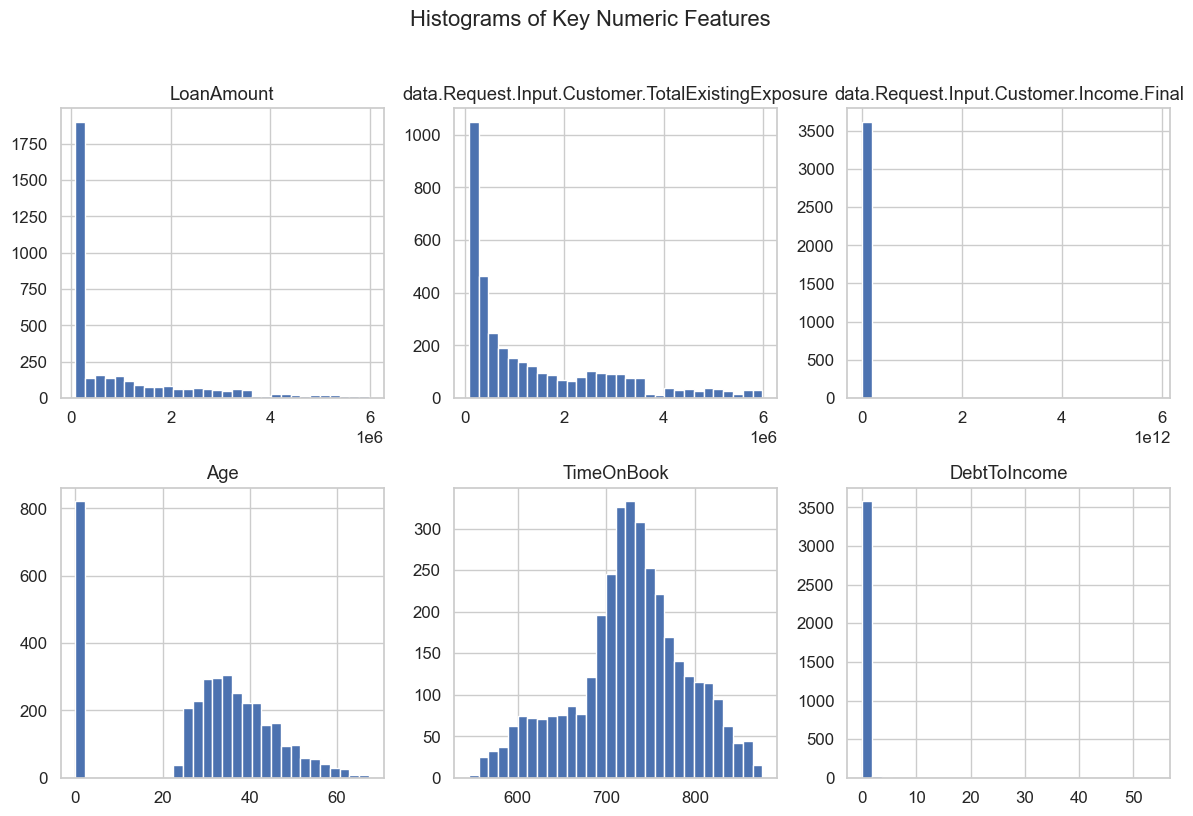

In [41]:
# Feature distributions for numeric columns
num_cols = [
    "LoanAmount",
    "data.Request.Input.Customer.TotalExistingExposure",
    "data.Request.Input.Customer.Income.Final",
    "Age",
    "TimeOnBook",
    "DebtToIncome",
]
df[num_cols].hist(bins=30, figsize=(12,8), layout=(2,3))
plt.suptitle("Histograms of Key Numeric Features", y=1.02)
plt.tight_layout()
plt.show()


In [42]:
# Encooding some labels 

ord_map = {"Sub-Prime": 0, "Near-Prime": 1, "Prime": 2}

df["CB2_Label"] = df["data.Request.Input.CB2.Labelling"].map(ord_map)
df["CB1_Label"] = df["data.Request.Input.CB1.Labelling"].map(ord_map)

df[["data.Request.Input.CB2.Labelling","CB2_Label"]].drop_duplicates()


,data.Request.Input.CB2.Labelling,CB2_Label
0,Sub-Prime,0.0
1,Near-Prime,1.0
2,NTC,NaN
3,Prime,2.0


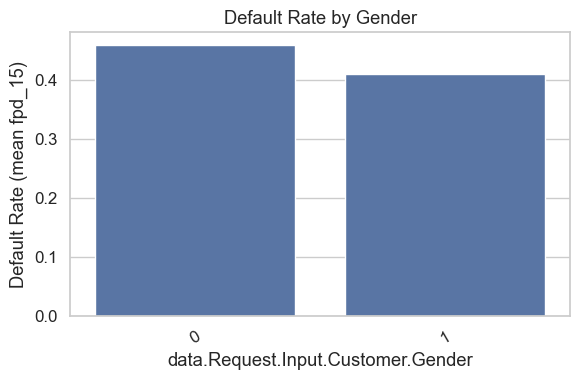

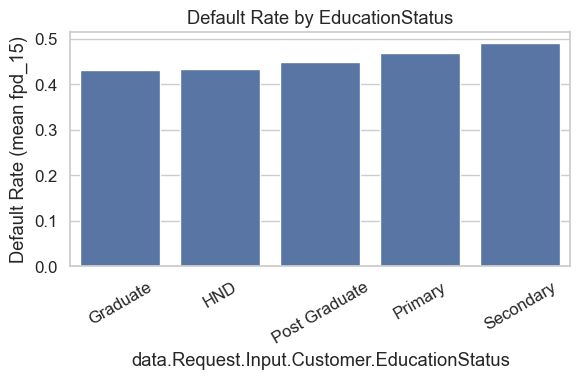

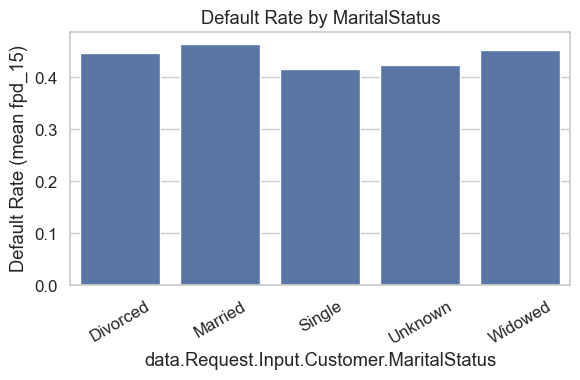

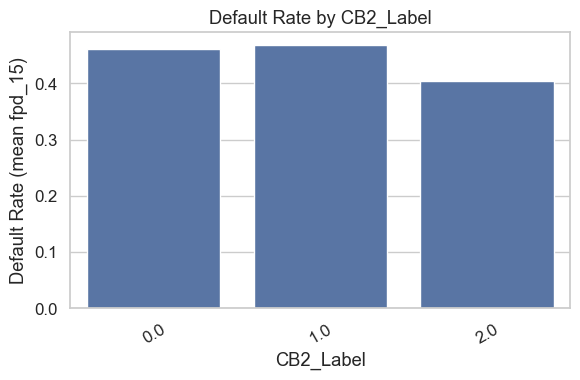

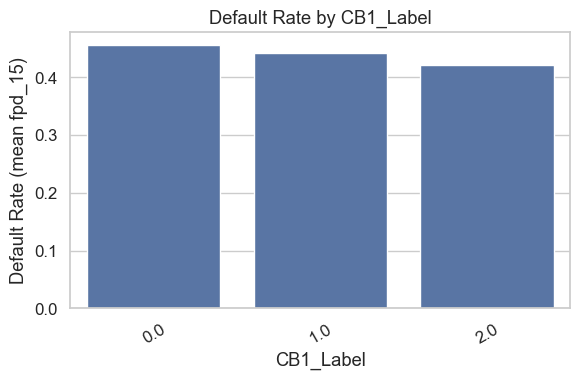

In [43]:
# categorical features and their default rates
cat_cols = [
    "data.Request.Input.Customer.Gender",
    "data.Request.Input.Customer.EducationStatus",
    "data.Request.Input.Customer.MaritalStatus",
    "CB2_Label",
    "CB1_Label"
]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    grp = df.groupby(col)["fpd_15"].mean().reset_index()
    sns.barplot(x=col, y="fpd_15", data=grp)
    plt.title(f"Default Rate by {col.split('.')[-1]}")
    plt.ylabel("Default Rate (mean fpd_15)")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


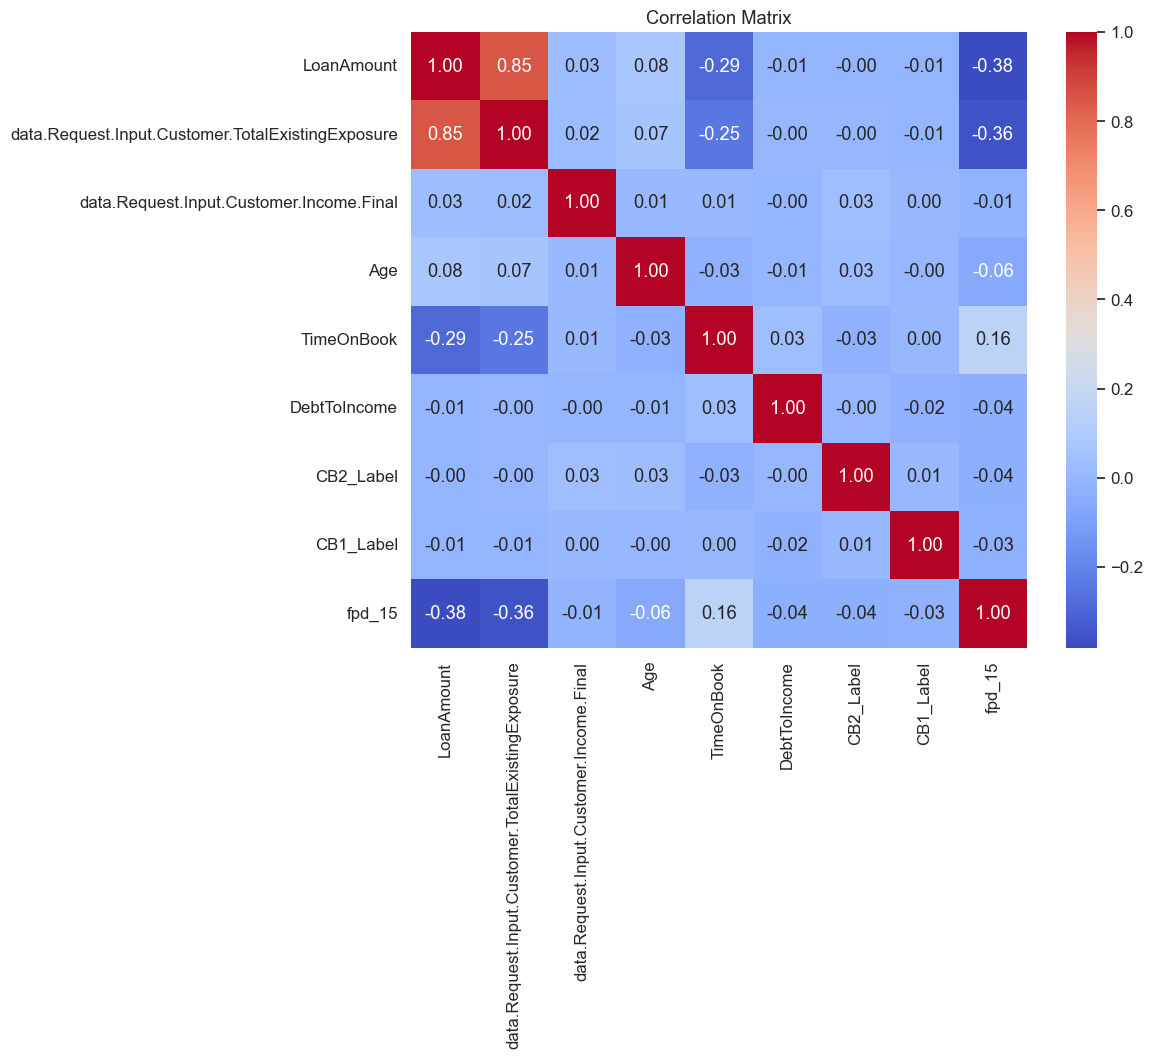

In [44]:
# Correlation heatmap
import seaborn as sns
corr_feats = num_cols + ["CB2_Label", "CB1_Label", "fpd_15"]
corr = df[corr_feats].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show() 



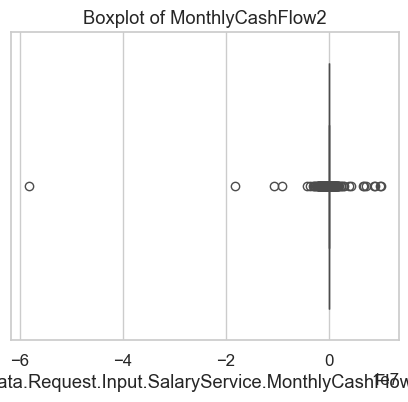

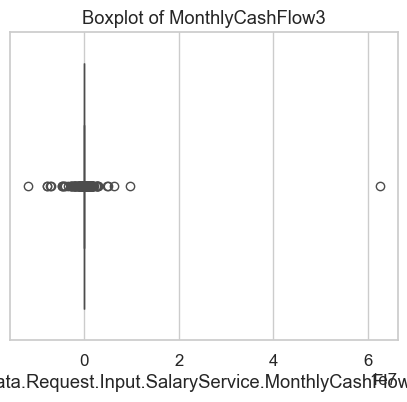

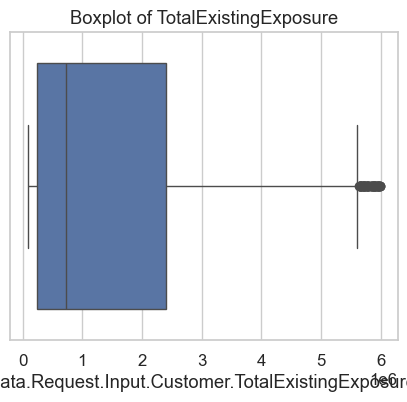

In [45]:
# Chck for outliers in some numeric features
cashflow_cols = [
    "data.Request.Input.SalaryService.MonthlyCashFlow2",
    "data.Request.Input.SalaryService.MonthlyCashFlow3",
    "data.Request.Input.Customer.TotalExistingExposure"
]

for col in cashflow_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col.split('.')[-1]}")
    plt.show()


In [46]:
%pip install scipy

from scipy.stats.mstats import winsorize
df["Income_wins"] = winsorize(df["data.Request.Input.Customer.Income.Final"], limits=[0.01,0.01])


Note: you may need to restart the kernel to use updated packages.


In [47]:
from scipy.stats.mstats import winsorize
df["Income_wins"] = winsorize(df["data.Request.Input.Customer.Income.Final"], limits=[0.01,0.01])

In [48]:
df.head()

,Index,LoanAmount,CreationDate,fpd_15,data.Request.Input.CB2.MaxDPD,data.Request.Input.CB2.Labelling,data.Request.Input.CB2.CurrentDPD,data.Request.Input.CB2.Outstandingloan,data.Request.Input.CB1.MaxDPD,data.Request.Input.CB1.Labelling,...,data.Request.Input.PrevApplication.LoanTerm,data.Request.Input.PrevApplication.InterestRate,data.Request.Input.Application.RequestedLoanTerm,data.Request.Input.SalaryService.OpeningBalance,Age,TimeOnBook,DebtToIncome,CB2_Label,CB1_Label,Income_wins
0,0,1410000.0,2023-09-04,0,0.0,Sub-Prime,0.0,70000.0,0.0,Prime,...,13.0,12.0,17.0,30000.0,0.0,631,0.175391,0.0,2.0,14442000.0
1,1,710000.0,2023-06-26,0,0.0,Near-Prime,0.0,0.0,0.0,Near-Prime,...,13.0,12.0,18.0,45000.0,36.3,701,1.198997,1.0,1.0,598000.0
2,2,5640000.0,2023-08-20,0,0.0,NTC,0.0,20000.0,0.0,Prime,...,18.0,12.0,14.0,30000.0,43.3,646,0.098621,NaN,2.0,49888000.0
3,3,120000.0,2023-05-22,1,0.0,Prime,0.0,0.0,0.0,NTC,...,15.0,13.0,14.0,30000.0,30.0,736,0.105971,2.0,NaN,1859000.0
4,4,160000.0,2023-05-17,0,0.0,Sub-Prime,0.0,140000.0,0.0,Sub-Prime,...,13.0,12.0,12.0,30000.0,42.7,741,0.114135,0.0,0.0,1323000.0


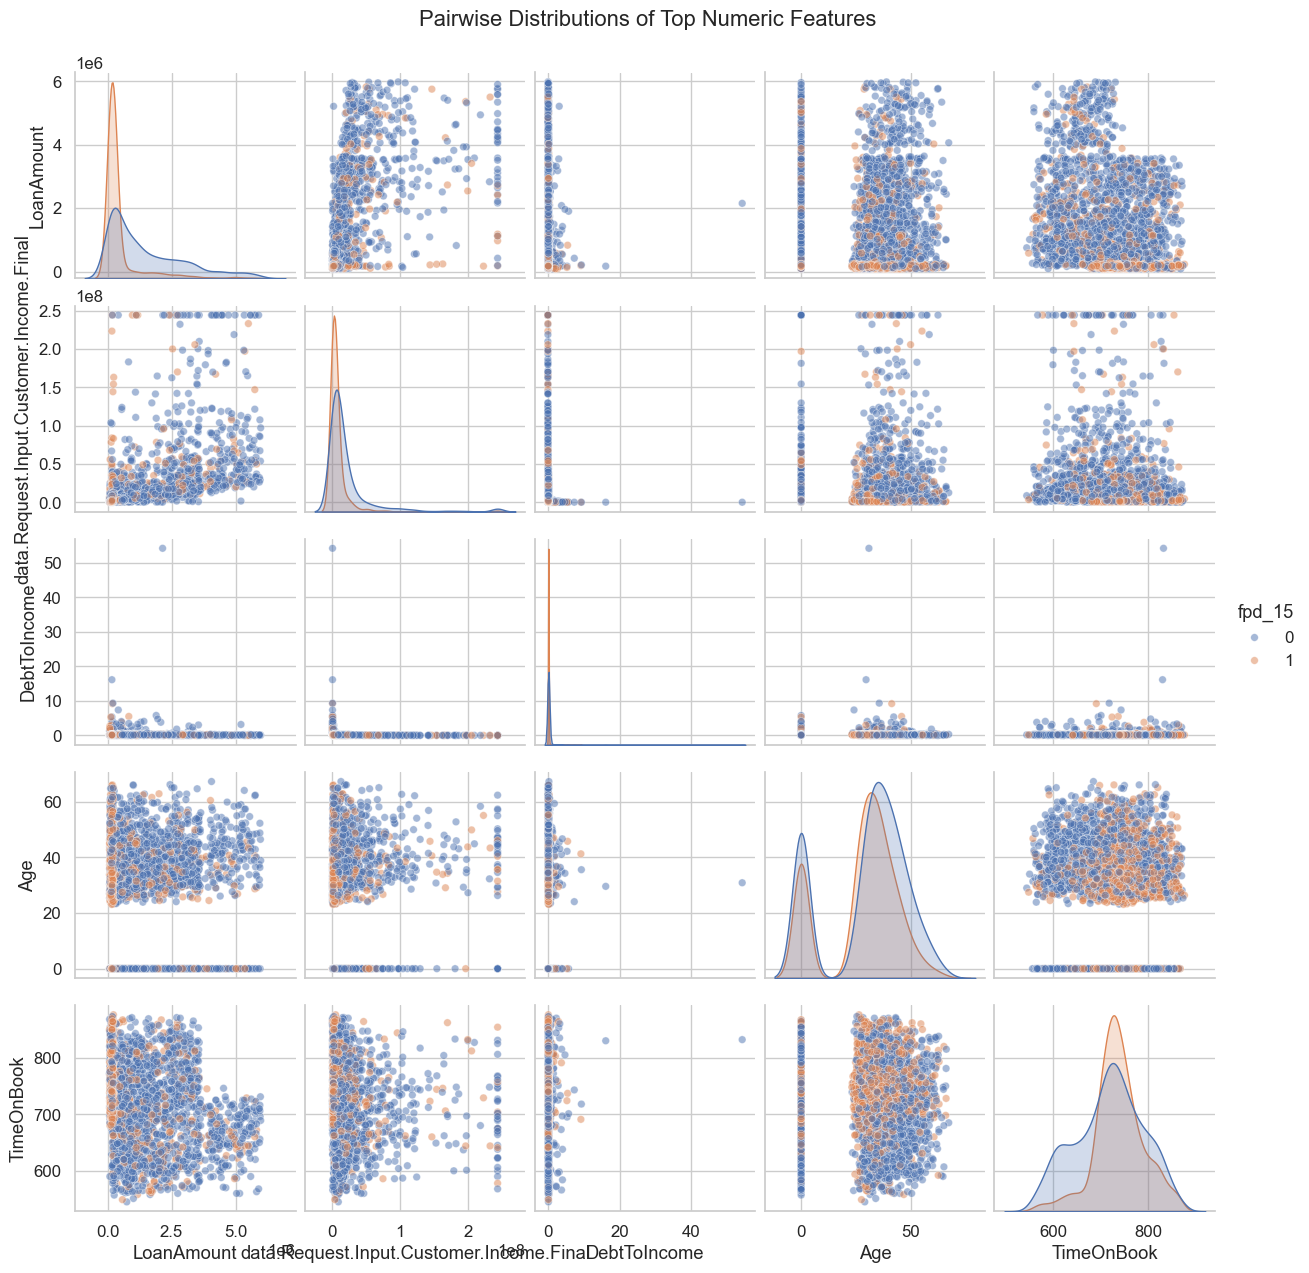

In [50]:
# Pairplot of top predictive features
top_feats = [
    "LoanAmount",
    "data.Request.Input.Customer.Income.Final",
    "DebtToIncome",
    "Age",
    "TimeOnBook"
]
sns.pairplot(
    df[top_feats + ["fpd_15"]],
    hue="fpd_15",
    vars=top_feats,
    plot_kws={"alpha": 0.5, "s": 30}
)
plt.suptitle("Pairwise Distributions of Top Numeric Features", y=1.02)
plt.show()


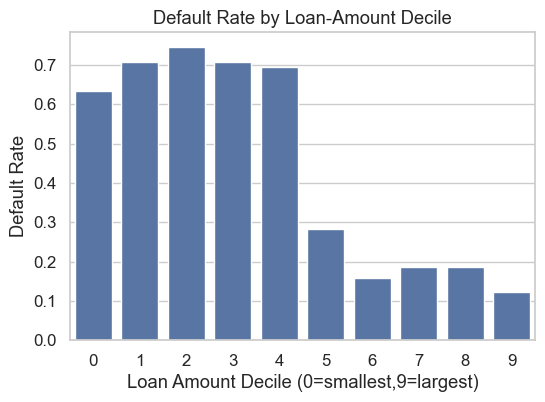

In [51]:
# Loan amount deciles and default rates - See if larger loans have higher default rates

df["LoanDecile"] = pd.qcut(df["LoanAmount"], 10, labels=False)
decile_rate = df.groupby("LoanDecile")["fpd_15"].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=decile_rate.index, y=decile_rate.values)
plt.xlabel("Loan Amount Decile (0=smallest,9=largest)")
plt.ylabel("Default Rate")
plt.title("Default Rate by Loan-Amount Decile")
plt.show()


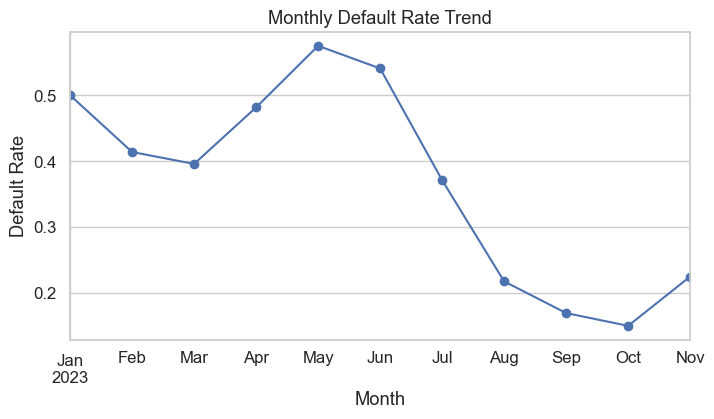

In [52]:
# Showing the trend of default rates over time


df["Month"] = df["CreationDate"].dt.to_period("M").dt.to_timestamp()
trend = df.groupby("Month")["fpd_15"].mean()

plt.figure(figsize=(8,4))
trend.plot(marker="o", linestyle="-")
plt.ylabel("Default Rate")
plt.title("Monthly Default Rate Trend")
plt.grid(True)
plt.show()


C:\Users\HP PAVILION 15 CS\AppData\Local\Temp\ipykernel_18512\1499252700.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(dist, method="average")


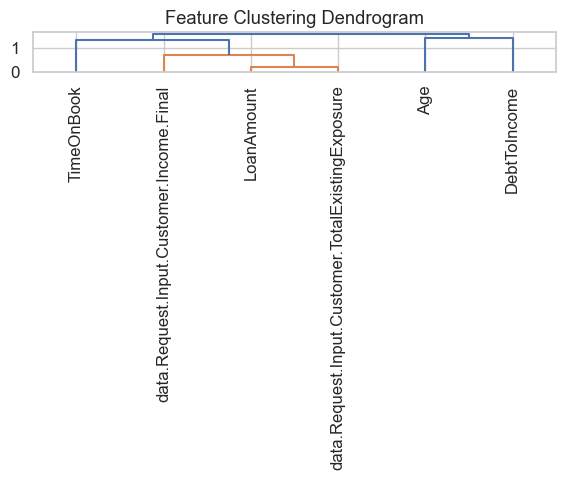

In [53]:
# detect redundant features using hierarchical clustering
from scipy.cluster import hierarchy

corr = df[num_cols].corr()
# distance matrix
dist = 1 - np.abs(corr)
linkage = hierarchy.linkage(dist, method="average")
plt.figure(figsize=(6,5))
dn = hierarchy.dendrogram(linkage, labels=corr.columns, leaf_rotation=90)
plt.title("Feature Clustering Dendrogram")
plt.tight_layout()
plt.show()


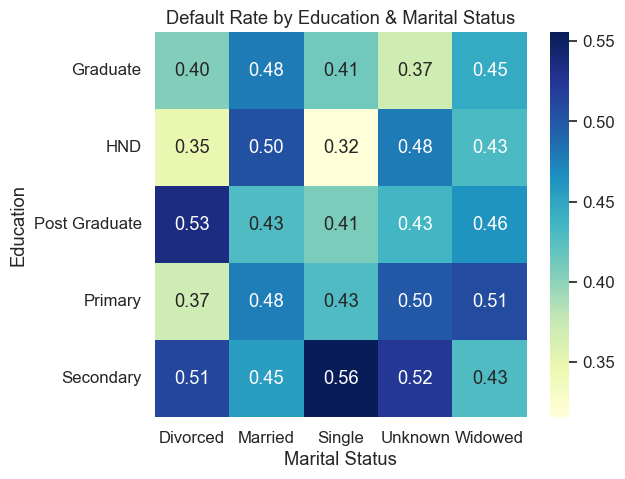

In [54]:
# Segmentation of default rates by education and marital status 

pivot = df.pivot_table(
    index="data.Request.Input.Customer.EducationStatus",
    columns="data.Request.Input.Customer.MaritalStatus",
    values="fpd_15",
    aggfunc="mean"
)
plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Default Rate by Education & Marital Status")
plt.ylabel("Education")
plt.xlabel("Marital Status")
plt.show()


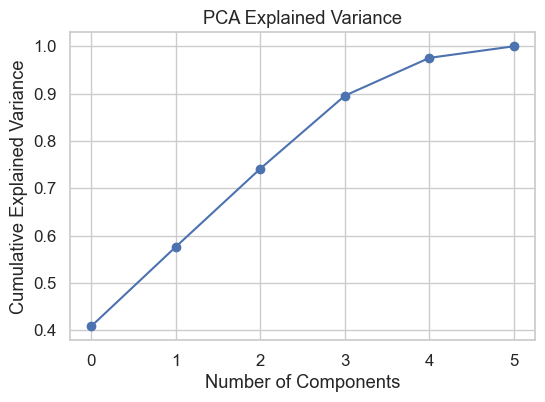

In [55]:
# PCA to reduce dimensionality and visualize variance explained

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(df[num_cols])
pca = PCA()
pca.fit(X_std)
var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(var_ratio), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()
